<h2>Part A: Linear Classification Models

<h5>Data Preparation

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset, Subset
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))]) #flatten 28*28 to 784 features

train_data_MNIST = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data_MNIST  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

full_data_MNIST = ConcatDataset([train_data_MNIST, test_data_MNIST])
targets = np.concatenate((train_data_MNIST.targets.numpy(),test_data_MNIST.targets.numpy()))
indices = np.arange(len(targets))

train_idx, temp_idx, y_train, y_temp = train_test_split(indices, targets, test_size=0.4, stratify=targets, random_state=42)
val_idx, test_idx, y_val, y_test = train_test_split(temp_idx, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

train_dataset = Subset(full_data_MNIST, train_idx)
val_dataset   = Subset(full_data_MNIST, val_idx)
test_dataset  = Subset(full_data_MNIST, test_idx)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

mask = (targets == 0) | (targets == 1)
filtered_indices = indices[mask]
filtered_targets = targets[mask]
train_idx_bin, temp_idx_bin, y_train_bin, y_temp_bin = train_test_split(filtered_indices, filtered_targets,test_size=0.4, stratify=filtered_targets, random_state=42)
val_idx_bin, test_idx_bin, y_val_bin, y_test_bin = train_test_split(temp_idx_bin, y_temp_bin,test_size=0.5, stratify=y_temp_bin, random_state=42)

train_dataset_bin = Subset(full_data_MNIST, train_idx_bin)
val_dataset_bin   = Subset(full_data_MNIST, val_idx_bin)
test_dataset_bin = Subset(full_data_MNIST, test_idx_bin)

train_loader_bin = DataLoader(train_dataset_bin, batch_size=64, shuffle=True)
val_loader_bin = DataLoader(val_dataset_bin, batch_size=64, shuffle=False)
test_loader_bin = DataLoader(test_dataset_bin, batch_size=64, shuffle=False)



<h3>Logistic Regression Implementation

<h5>Binary Classification Task

In [ ]:
import torch

class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Define the single linear layer
        self.linear = nn.Linear(784, 1)
    def forward(self, x):
        # Pass input x through the linear layer
        outputs = self.linear(x)
        # Return the outputs
        return outputs
    
model = LogisticRegression()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
num_epochs = 30
train_loss_history = []
val_loss_history = []
val_acc_history = []
train_acc_history = []

for epoch in range(num_epochs):
    
    model.train() 
    train_loss = 0.0
    train_samples = 0
    train_correct_preds = 0
    for images, labels in train_loader_bin:
       optimizer.zero_grad()
       outputs = model(images)
       labels_reshaped = labels.float().view(-1, 1)
       loss = criterion(outputs, labels_reshaped)
       loss.backward()
       optimizer.step()
       train_loss += loss.item() * images.size(0)
       train_samples += labels.size(0)
       predicted_classes = (outputs > 0)
       train_correct_preds += (predicted_classes == labels_reshaped).sum().item()
      
    avg_train_loss = train_loss / train_samples
    train_accuracy = train_correct_preds / train_samples

    train_acc_history.append(train_accuracy)
    train_loss_history.append(avg_train_loss)

    
    model.eval() 
    val_loss = 0.0
    correct_preds = 0
    total_samples = 0
    # We don't need gradients for validation
    with torch.no_grad():
        for images, labels in val_loader_bin:
            outputs = model(images)
            
            labels_reshaped = labels.float().view(-1, 1)
            loss = criterion(outputs, labels_reshaped)
            val_loss += loss.item() * images.size(0)
            
            predicted_classes = (outputs > 0)
            correct_preds += (predicted_classes == labels_reshaped).sum().item()
            total_samples += labels.size(0)
    avg_val_loss = val_loss / total_samples
    val_accuracy = correct_preds / total_samples
    
    val_loss_history.append(avg_val_loss)
    val_acc_history.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: ..., Train Accuracy: ..., Val Loss: ..., Val Accuracy: ...')
    print(f"Epoch [{epoch+1}/{num_epochs}] | " f"Train Loss: {avg_train_loss:.4f} | " f"Train Acc: {train_accuracy*100:.2f}| "f"Val Loss: {avg_val_loss:.4f} | " f"Val Acc: {val_accuracy*100:.2f}%")



Epoch [1/30], Train Loss: ..., Train Accuracy: ..., Val Loss: ..., Val Accuracy: ...
Epoch [1/30] | Train Loss: 0.2131 | Train Acc: 97.90| Val Loss: 0.0934 | Val Acc: 99.59%
Epoch [2/30], Train Loss: ..., Train Accuracy: ..., Val Loss: ..., Val Accuracy: ...
Epoch [2/30] | Train Loss: 0.0692 | Train Acc: 99.73| Val Loss: 0.0550 | Val Acc: 99.63%
Epoch [3/30], Train Loss: ..., Train Accuracy: ..., Val Loss: ..., Val Accuracy: ...
Epoch [3/30] | Train Loss: 0.0461 | Train Acc: 99.72| Val Loss: 0.0408 | Val Acc: 99.63%
Epoch [4/30], Train Loss: ..., Train Accuracy: ..., Val Loss: ..., Val Accuracy: ...
Epoch [4/30] | Train Loss: 0.0359 | Train Acc: 99.72| Val Loss: 0.0333 | Val Acc: 99.70%
Epoch [5/30], Train Loss: ..., Train Accuracy: ..., Val Loss: ..., Val Accuracy: ...
Epoch [5/30] | Train Loss: 0.0300 | Train Acc: 99.73| Val Loss: 0.0285 | Val Acc: 99.70%
Epoch [6/30], Train Loss: ..., Train Accuracy: ..., Val Loss: ..., Val Accuracy: ...
Epoch [6/30] | Train Loss: 0.0261 | Train Acc

<h4> Test evaluation

In [ ]:
model.eval() # Set model to evaluation mode
test_correct_preds = 0
test_total_samples = 0
all_preds = []
all_labels = []

with torch.no_grad(): 
    
    for images, labels in test_loader_bin: 
        
        # Get model outputs
        outputs = model(images)
        labels_reshaped = labels.float().view(-1, 1)
        
       
        predicted_classes = (outputs > 0)
        
        # Add to total correct predictions
        test_correct_preds += (predicted_classes == labels_reshaped).sum().item()
        test_total_samples += labels.size(0)
        
        # --- Store for Confusion Matrix ---
        # .cpu() moves data from GPU (if used) back to CPU
        all_preds.extend(predicted_classes.cpu().numpy())
        all_labels.extend(labels_reshaped.cpu().numpy())

# Calculate and print final test accuracy
final_test_accuracy = test_correct_preds / test_total_samples
print(f"Final Test Accuracy: {final_test_accuracy * 100:.2f}%")

Final Test Accuracy: 99.80%


<h3>Confusion matrix

In [5]:
tp = 0 
tn = 0 
fp = 0 
fn = 0 

for pred, label in zip(all_preds, all_labels):
    if pred == True and label == 1.0:
        tp += 1
    elif pred == False and label == 0.0:
        tn += 1
    elif pred == True and label == 0.0:
        fp += 1
    elif pred == False and label == 1.0:
        fn += 1

print("\n Confusion Matrix Manual")
print("                     Predicted")
print("                    NEG (0) | POS (1)")
print("---------------------------------------")
print(f"Actual NEG (0) |  {tn:^6}  |  {fp:^6}")
print("---------------------------------------")
print(f"Actual POS (1) |  {fn:^6}  |  {tp:^6}")
print("---------------------------------------")
acc = (tp + tn) / (tp + tn + fp + fn)
print(f"\nAccuracy from CM: {acc * 100:.2f}%")


 Confusion Matrix Manual
                     Predicted
                    NEG (0) | POS (1)
---------------------------------------
Actual NEG (0) |   1378   |    3   
---------------------------------------
Actual POS (1) |    3     |   1572 
---------------------------------------

Accuracy from CM: 99.80%


<h3>plot Curves

<h3>1.training vs validation loss

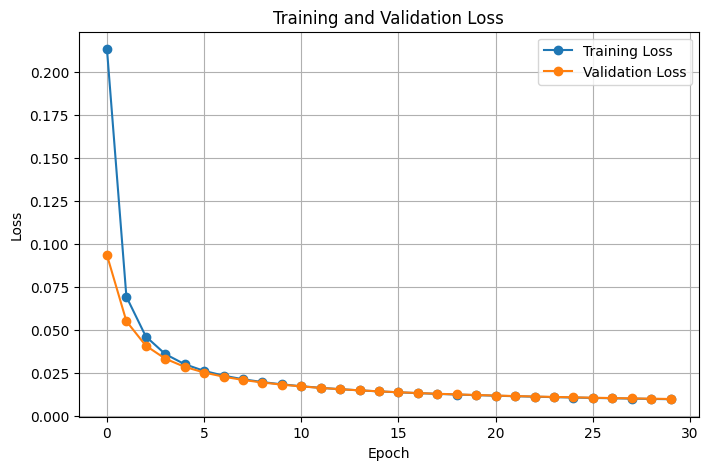

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(train_loss_history, label='Training Loss', marker='o')
plt.plot(val_loss_history, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


<h3>2.Training and validation accuracy

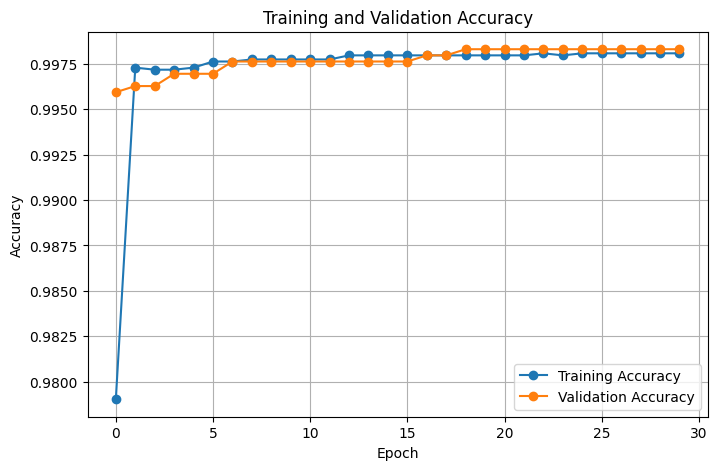

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(train_acc_history, label='Training Accuracy', marker='o')
plt.plot(val_acc_history, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


<h4>Softmax regression

In [ ]:
import torch.nn as nn

class SoftmaxRegression(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear = nn.Linear(784, 10) 
    
    def forward(self, x):
        outputs = self.linear(x)
        return outputs
model = SoftmaxRegression()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

num_epochs = 30 # Or as needed

for epoch in range(num_epochs):
    
    #  TRAINING PHASE
    model.train()
    train_loss = 0.0
    train_correct_preds = 0
    train_samples = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        train_samples += labels.size(0)

        predicted_classes = torch.argmax(outputs, dim=1)

        train_correct_preds += (predicted_classes == labels).sum().item()
    avg_train_loss = train_loss / train_samples
    avg_train_acc = train_correct_preds / train_samples
    train_loss_history.append(avg_train_loss)
    train_acc_history.append(avg_train_acc)
    model.eval()
    val_loss = 0.0
    val_correct_preds = 0
    val_samples = 0
    with torch.no_grad():
        
        for images, labels in val_loader:
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            
            predicted_classes = torch.argmax(outputs, dim=1)
            val_correct_preds += (predicted_classes == labels).sum().item()
            val_samples += labels.size(0)
            
    avg_val_loss = val_loss / val_samples
    avg_val_acc = val_correct_preds / val_samples
    val_loss_history.append(avg_val_loss)
    val_acc_history.append(avg_val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Train Acc: {avg_train_acc*100:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {avg_val_acc*100:.2f}%")

Epoch [1/30] | Train Loss: 1.1048 | Train Acc: 78.92% | Val Loss: 0.7137 | Val Acc: 84.46%
Epoch [2/30] | Train Loss: 0.6167 | Train Acc: 85.97% | Val Loss: 0.5563 | Val Acc: 86.54%
Epoch [3/30] | Train Loss: 0.5168 | Train Acc: 87.36% | Val Loss: 0.4925 | Val Acc: 87.58%
Epoch [4/30] | Train Loss: 0.4683 | Train Acc: 88.18% | Val Loss: 0.4566 | Val Acc: 88.19%
Epoch [5/30] | Train Loss: 0.4386 | Train Acc: 88.65% | Val Loss: 0.4331 | Val Acc: 88.59%
Epoch [6/30] | Train Loss: 0.4180 | Train Acc: 89.07% | Val Loss: 0.4161 | Val Acc: 88.94%
Epoch [7/30] | Train Loss: 0.4026 | Train Acc: 89.34% | Val Loss: 0.4031 | Val Acc: 89.13%
Epoch [8/30] | Train Loss: 0.3904 | Train Acc: 89.58% | Val Loss: 0.3932 | Val Acc: 89.34%
Epoch [9/30] | Train Loss: 0.3807 | Train Acc: 89.79% | Val Loss: 0.3844 | Val Acc: 89.61%
Epoch [10/30] | Train Loss: 0.3724 | Train Acc: 89.94% | Val Loss: 0.3773 | Val Acc: 89.79%
Epoch [11/30] | Train Loss: 0.3654 | Train Acc: 90.13% | Val Loss: 0.3717 | Val Acc: 89.8

<h4> Test evaluation

In [9]:
model.eval() # Set model to evaluation mode
test_correct_preds = 0
test_total_samples = 0
all_preds = []
all_labels = []

with torch.no_grad(): 
    
    for images, labels in test_loader: 
        
        # Get model outputs
        outputs = model(images)
        
       
        predicted_classes = torch.argmax(outputs, dim=1)
        test_correct_preds += (predicted_classes == labels).sum().item()
        test_total_samples += labels.size(0)
        
        # for confusion Matrix 
        # .cpu() moves data from GPU (if used) back to CPU
        all_preds.extend(predicted_classes.cpu())
        all_labels.extend(labels.cpu())

# Calculate and print final test accuracy
final_test_accuracy = test_correct_preds / test_total_samples
print(f"Final Test Accuracy: {final_test_accuracy * 100:.2f}%")

Final Test Accuracy: 90.90%


In [10]:


# initialize a 10x10 matrix of zeros
confusion_matrix = torch.zeros((10, 10), dtype=torch.int64)

# Loop through all the collected predictions and labels
for label, pred in zip(all_labels, all_preds):
    # Increment the count at the (actual, predicted) cell
    confusion_matrix[label, pred] += 1 

print("\n Confusion Matrix Manual")
print(confusion_matrix)

correct_per_class = confusion_matrix.diag()

# Get the total number of samples for each class (the row sums)
total_per_class = confusion_matrix.sum(dim=1)

# calculate the accuracy for each class
# Add 1e-6 to avoid division by zero if a class has no samples
per_class_accuracy = correct_per_class.float() / (total_per_class.float() + 1e-6)

print("\n--- Per-Class Accuracy ---")
for i in range(10):
    print(f"Class {i}: {per_class_accuracy[i] * 100:.2f}%")


 Confusion Matrix Manual
tensor([[1332,    0,    7,    3,    2,   10,    8,    1,   14,    3],
        [   1, 1524,    6,    7,    1,   10,    1,    3,   19,    3],
        [  10,   10, 1231,   25,   27,    2,   24,   26,   31,   12],
        [   8,   12,   27, 1253,    3,   51,    9,   25,   31,   10],
        [   3,    9,    7,    2, 1252,    1,   13,    3,    9,   66],
        [  19,   12,   15,   42,   10, 1077,   30,    5,   38,   15],
        [  12,    4,   14,    1,    7,   16, 1307,    2,   12,    0],
        [   8,   14,   18,    9,   11,    1,    0, 1338,    5,   55],
        [  16,   35,   16,   32,    8,   39,   14,    9, 1178,   18],
        [  13,    6,    8,   18,   53,    9,    2,   39,    9, 1234]])

--- Per-Class Accuracy ---
Class 0: 96.52%
Class 1: 96.76%
Class 2: 88.05%
Class 3: 87.68%
Class 4: 91.72%
Class 5: 85.27%
Class 6: 95.05%
Class 7: 91.71%
Class 8: 86.30%
Class 9: 88.71%


<h3>plot Curves

<h3>1.training vs validation loss

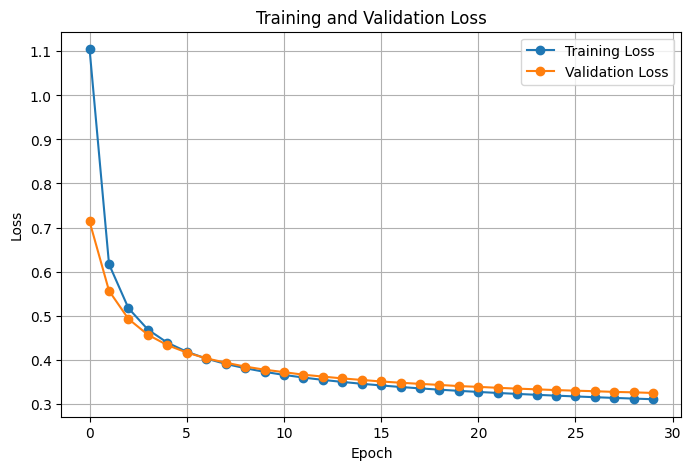

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(train_loss_history, label='Training Loss', marker='o')
plt.plot(val_loss_history, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


<h3>2.Training and validation accuracy

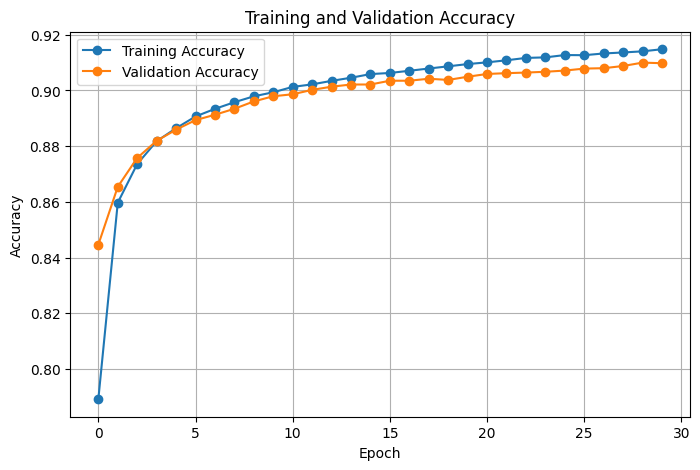

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(train_acc_history, label='Training Accuracy', marker='o')
plt.plot(val_acc_history, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Part B: Neural Network Implementation

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class SimpleFNN(nn.Module):
    def __init__(self,num_classes=10):
        super(SimpleFNN, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, num_classes)
        # --- Weight Initialization ---
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.fc3.weight)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x= F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
import torchvision
import torchvision.transforms as transforms

# Define the transform: Convert images to PyTorch Tensors
transform = transforms.ToTensor()
# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64
train=DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test=DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [17]:
import torch.optim as optim


model = SimpleFNN()
model.to(device)

loss=nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


In [18]:
NUM_EPOCHS = 12
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    for images,labels in train:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs=model(images)

        l=loss(outputs,labels)
        l.backward()
        optimizer.step()
        
        running_loss += l.item()
        # Get training accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
   
    epoch_loss = running_loss / len(train)
    train_loss_history.append(epoch_loss)
    epoch_train_acc = 100 * train_correct / train_total
    train_acc_history.append(epoch_train_acc)


    model.eval() 
    correct = 0
    total = 0
    val_running_loss = 0.0

    with torch.no_grad(): 
        for images, labels in test: 
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            l= loss(outputs, labels) 
            val_running_loss += l.item()
            correct+=(predicted==labels).sum().item()

    epoch_val_loss = val_running_loss / len(test)
    epoch_val_acc = 100 * correct / total

    val_loss_history.append(epoch_val_loss)
    val_acc_history.append(epoch_val_acc)

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], '
      f'Train Loss: {epoch_loss:.4f}, '
      f'Train Acc: {epoch_train_acc:.2f}%, '
      f'Val Loss: {epoch_val_loss:.4f}, '
      f'Val Acc: {epoch_val_acc:.2f}%')

Epoch [1/12], Train Loss: 0.3195, Train Acc: 90.48%, Val Loss: 0.1674, Val Acc: 95.02%
Epoch [2/12], Train Loss: 0.1389, Train Acc: 95.87%, Val Loss: 0.1255, Val Acc: 96.21%
Epoch [3/12], Train Loss: 0.0992, Train Acc: 97.04%, Val Loss: 0.0979, Val Acc: 96.82%
Epoch [4/12], Train Loss: 0.0773, Train Acc: 97.67%, Val Loss: 0.0954, Val Acc: 96.90%
Epoch [5/12], Train Loss: 0.0636, Train Acc: 98.09%, Val Loss: 0.0878, Val Acc: 97.21%
Epoch [6/12], Train Loss: 0.0530, Train Acc: 98.41%, Val Loss: 0.0709, Val Acc: 97.70%
Epoch [7/12], Train Loss: 0.0443, Train Acc: 98.65%, Val Loss: 0.0776, Val Acc: 97.51%
Epoch [8/12], Train Loss: 0.0375, Train Acc: 98.84%, Val Loss: 0.0727, Val Acc: 97.67%
Epoch [9/12], Train Loss: 0.0307, Train Acc: 99.09%, Val Loss: 0.0738, Val Acc: 97.61%
Epoch [10/12], Train Loss: 0.0251, Train Acc: 99.28%, Val Loss: 0.0707, Val Acc: 97.84%
Epoch [11/12], Train Loss: 0.0224, Train Acc: 99.40%, Val Loss: 0.0786, Val Acc: 97.70%
Epoch [12/12], Train Loss: 0.0178, Train 

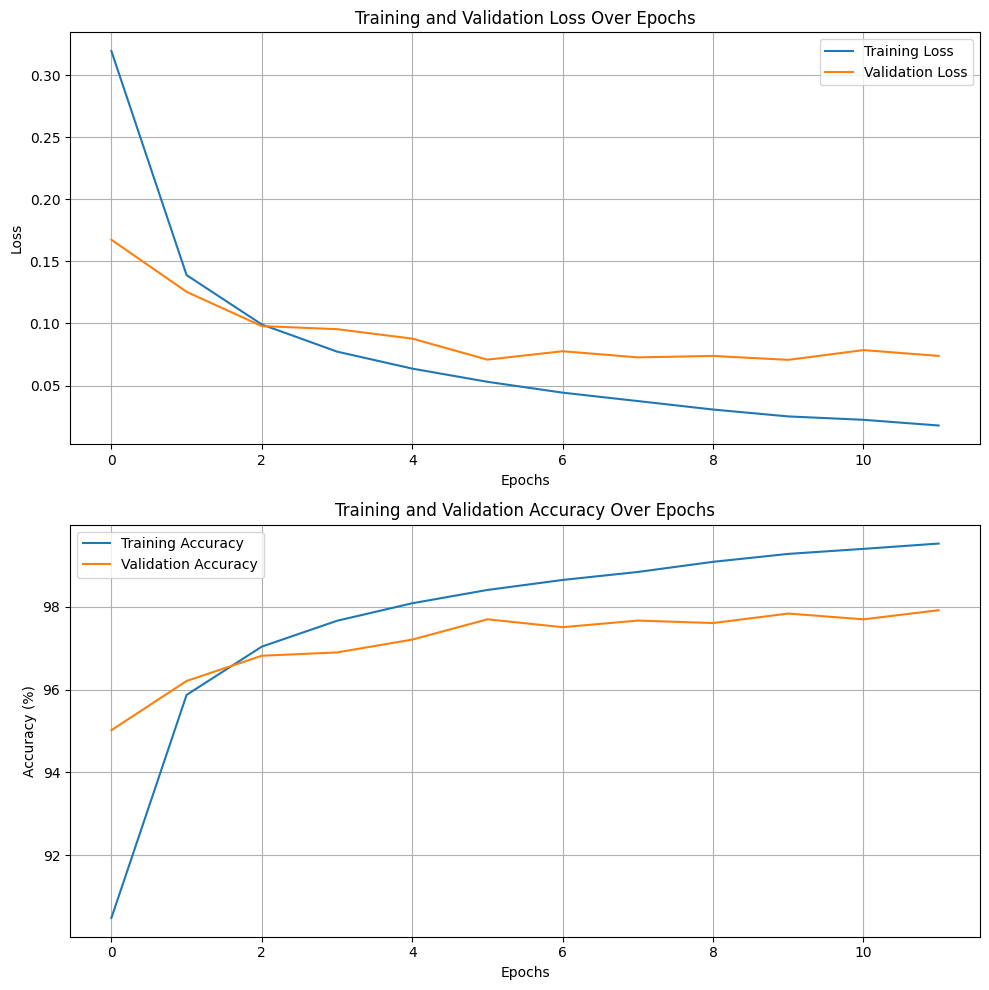

In [19]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot 1: Training & Validation Loss
ax1.plot(train_loss_history, label='Training Loss')
ax1.plot(val_loss_history, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss Over Epochs')
ax1.legend()
ax1.grid(True)

# Plot 2: Training & Validation Accuracy
ax2.plot(train_acc_history, label='Training Accuracy')
ax2.plot(val_acc_history, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy Over Epochs')
ax2.legend()
ax2.grid(True)


plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

Part C: Comprehensive Analysis

Part D: Advanced Techniques